### FastSpecFit Nebular Lines

Develop the set of nebular emission lines that *fastspecfit* should model.

In [33]:
import pdb
import numpy as np
import pyneb as pn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set(context='talk', style='ticks', palette='deep', font_scale=1.1)
colors = sns.color_palette()

%matplotlib inline

In [4]:
def air2vac(airwave):
    """http://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion"""
    if airwave <= 0:
        raise ValueError('Input wavelength is not defined.')
    ss = 1e4 / airwave
    nn = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - ss**2) + 0.0001599740894897 / (38.92568793293 - ss**2)
    return airwave * nn

In [18]:
def atominfo(atom='Ne', ion=3, temp=1e4, dens=1e2):
    atm = pn.Atom(atom, ion)
    nlevel = atm.NLevels
    emis = atm.getEmissivity(temp, dens)
    for i in range(1, nlevel):
        for j in range(i):
            airwave = atm.wave_Ang[i, j]
            vacwave = air2vac(airwave)
            if airwave < 1.5e4 and emis[i, j] > 1e-23:
                print('[{}{}] ({}-->{}): airwave: {:.4f} vacwave: {:.4f} emissivity: {:.5e}'.format(
                    atom, ion, i+1, j+1, airwave, vacwave, emis[i, j]))

### Density and temperature dependence of the [OII] 3726,29, [SII] 6716,31, and [OII] 7320,30 doublets.

In [65]:
def get_doublet_ratio(atom, ion, dens, temp, iweak, istrong, label):
    ratio = np.zeros((ntemp, ndens))

    atm = pn.Atom(atom, ion)
    for jj in np.arange(ntemp):
        for ii in np.arange(ndens):
            emis = atm.getEmissivity(temp[jj], dens[ii])
            # [OII] 3726/3729, [OII] 7330/7320, or [SII] 6730/6716
            ratio[jj, ii] = emis[iweak[0], iweak[1]] / emis[istrong[0], istrong[1]] 
        print('{} = {:.5f} at n = {:.0f} / cm3, T = {:.0f} K'.format(label, ratio[jj, 0], dens[0], temp[jj]))
        print('{} = {:.5f} at n = {:.0f} / cm3, T = {:.0f} K'.format(
            label, np.interp(dens_nominal, dens, ratio[jj, :]), dens_nominal, temp[jj]))
        print('{} = {:.5f} at n = {:.0f} / cm3, T = {:.0f} K'.format(
            label, ratio[jj, -1], dens[-1], temp[jj]))
        print()
        
    ls = ['-', '--', '-.']
    fig, ax = plt.subplots(figsize=(8, 6))
    for jj in np.arange(ntemp):
        ax.plot(dens, ratio[jj, :], ls=ls[jj], 
                label='T = {:.0f} K'.format(temp[jj]))
    ax.margins(x=0, y=0.2)
    ax.axvline(x=100, ls='-', lw=2, color='k')
    ax.set_xlabel(r'Electron Density (cm$^{-3}$)')
    ax.set_ylabel(r'{}'.format(label))
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.legend(loc='upper left');

In [19]:
atominfo(atom='O', ion=2, temp=1e4, dens=1e2)

[O2] (2-->1): airwave: 3728.8145 vacwave: 3729.8750 emissivity: 1.94850e-21
[O2] (3-->1): airwave: 3726.0322 vacwave: 3727.0919 emissivity: 1.44403e-21
[O2] (4-->1): airwave: 2470.3405 vacwave: 2471.0873 emissivity: 3.51593e-23
[O2] (4-->2): airwave: 7319.9849 vacwave: 7322.0018 emissivity: 2.46153e-23
[O2] (4-->3): airwave: 7330.7308 vacwave: 7332.7506 emissivity: 1.28988e-23
[O2] (5-->3): airwave: 7329.6613 vacwave: 7331.6807 emissivity: 1.36728e-23


In [22]:
atominfo(atom='S', ion=2, temp=1e4, dens=1e2)

[S2] (2-->1): airwave: 6730.8124 vacwave: 6732.6705 emissivity: 2.09987e-20
[S2] (3-->1): airwave: 6716.4370 vacwave: 6718.2913 emissivity: 2.83717e-20
[S2] (4-->1): airwave: 4076.3490 vacwave: 4077.5000 emissivity: 6.62021e-22
[S2] (4-->2): airwave: 10336.4007 vacwave: 10339.2336 emissivity: 4.39830e-22
[S2] (4-->3): airwave: 10370.4869 vacwave: 10373.3291 emissivity: 2.04125e-22
[S2] (5-->1): airwave: 4068.5998 vacwave: 4069.7487 emissivity: 2.01249e-21
[S2] (5-->2): airwave: 10286.7212 vacwave: 10289.5407 emissivity: 4.47181e-22
[S2] (5-->3): airwave: 10320.4801 vacwave: 10323.3087 emissivity: 5.84844e-22


In [68]:
atominfo(atom='O', ion=3, temp=1e4, dens=1e2)

[O3] (4-->2): airwave: 4958.9097 vacwave: 4960.2937 emissivity: 1.17195e-21
[O3] (4-->3): airwave: 5006.8417 vacwave: 5008.2383 emissivity: 3.49707e-21
[O3] (5-->4): airwave: 4363.2088 vacwave: 4364.4351 emissivity: 2.27902e-23


In [69]:
atominfo(atom='N', ion=2, temp=1e4, dens=1e2)

[N2] (4-->2): airwave: 6548.0488 vacwave: 6549.8578 emissivity: 2.02198e-21
[N2] (4-->3): airwave: 6583.4511 vacwave: 6585.2696 emissivity: 5.94901e-21
[N2] (5-->4): airwave: 5754.5925 vacwave: 5756.1887 emissivity: 8.88829e-23
[N2] (6-->2): airwave: 2139.0081 vacwave: 2139.6825 emissivity: 3.28518e-23
[N2] (6-->3): airwave: 2142.7727 vacwave: 2143.4478 emissivity: 8.05380e-23


In [26]:
dens_nominal = 100
temp_nominal = 1e4

temp = np.array([5000.0, 1e4, 2e4])
ntemp = len(temp)

ndens = 30
dens = np.logspace(0, 3, ndens)

In [45]:
#atm = pn.Atom('O', 2)
#emis = atm.getEmissivity(1e4, 100)
#emis[3, 2], emis[3, 1]
##emis.shape

(1.2898822551648282e-23, 2.4615272232177782e-23)

[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.66300 at n = 1 / cm3, T = 5000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.76405 at n = 100 / cm3, T = 5000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 1.38312 at n = 1000 / cm3, T = 5000 K

[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.66703 at n = 1 / cm3, T = 10000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.74107 at n = 100 / cm3, T = 10000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 1.24098 at n = 1000 / cm3, T = 10000 K

[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.67479 at n = 1 / cm3, T = 20000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 0.73189 at n = 100 / cm3, T = 20000 K
[O II] $\lambda3726$ / [O II] $\lambda3729$ = 1.14352 at n = 1000 / cm3, T = 20000 K

-------------------------------------------------------
[S II] $\lambda6730$ / [S II] $\lambda6716$ = 0.67794 at n = 1 / cm3, T = 5000 K
[S II] $\lambda6730$ / [S II] $\lambda6716$ = 0.74998 at n = 100 / cm3, T = 5000 K
[S II] $\lambda6730$ / [S I

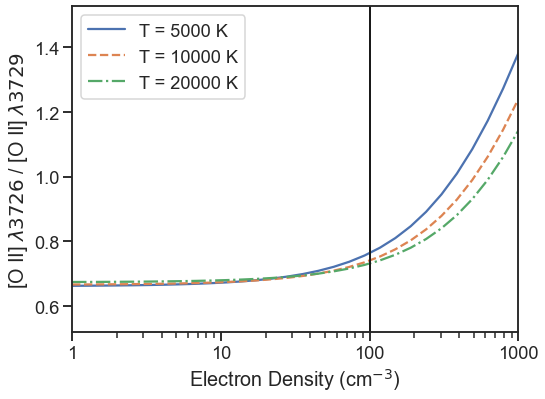

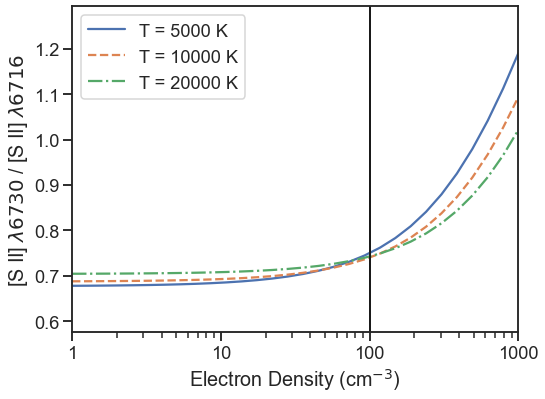

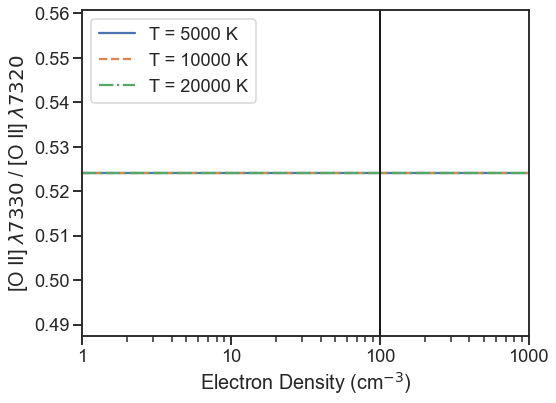

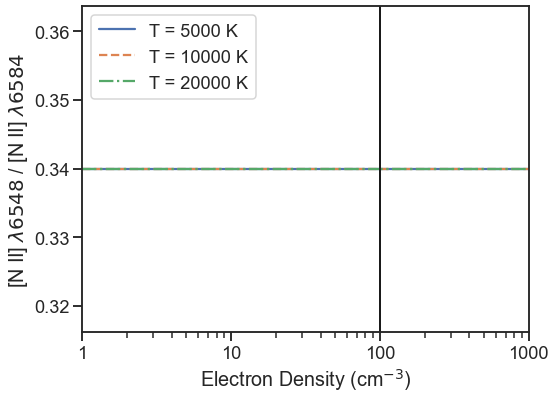

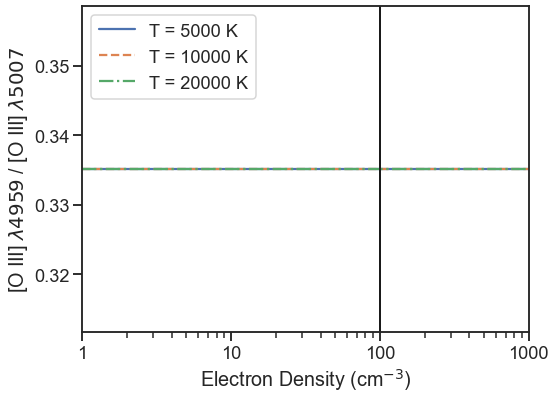

In [70]:
atoms = [
    'O', 
    'S', 
    'O',
    'N',
    'O',
]
ions = [
    2, 
    2, 
    2,
    2,
    3,
]
iweaks = [
    [2, 0], # [OII] 3726
    [1, 0], # [SII] 6730 - not necessarily weaker, but redder
    [3, 2], # [OII] 7330
    [3, 1], # [NII] 6548
    [3, 1], # [OIII] 4959    
] 
istrongs = [
    [1, 0], # [OII] 3729
    [2, 0], # [SII] 6716
    [3, 1], # [OII] 7320
    [3, 2], # [NII] 6584
    [3, 2], # [OIII] 5007
] 
labels = [
    '[O II] $\lambda3726$ / [O II] $\lambda3729$',
    '[S II] $\lambda6730$ / [S II] $\lambda6716$',
    '[O II] $\lambda7330$ / [O II] $\lambda7320$',
    '[N II] $\lambda6548$ / [N II] $\lambda6584$',
    '[O III] $\lambda4959$ / [O III] $\lambda5007$',
]

#print(iweaks[1], istrongs[1])
#get_doublet_ratio(atoms[1], ions[1], dens, temp, iweaks[1], istrongs[1])

for atom, ion, iweak, istrong, label in zip(atoms, ions, iweaks, istrongs, labels):
    get_doublet_ratio(atom, ion, dens, temp, iweak, istrong, label)
    print('-------------------------------------------------------')

### Building a complete line-list

In [8]:
allatoms = ('O', 'O', 'Ne', 'Ne', 'Ar', 'S')
allions = (2, 3, 3, 5, 3, 3)

In [8]:
for atom, ion in zip(allatoms, allions):
    atominfo(atom=atom, ion=ion)
    print()

[O2] (2-->1): airwave: 3728.8145 vacwave: 3729.8750 emissivity: 1.948e-21
[O2] (3-->1): airwave: 3726.0322 vacwave: 3727.0919 emissivity: 1.444e-21

[O3] (4-->2): airwave: 4958.9097 vacwave: 4960.2937 emissivity: 1.172e-21
[O3] (4-->3): airwave: 5006.8417 vacwave: 5008.2383 emissivity: 3.497e-21

[Ne3] (4-->1): airwave: 3868.7643 vacwave: 3869.8611 emissivity: 1.135e-21


[Ar3] (4-->1): airwave: 7135.7878 vacwave: 7137.7550 emissivity: 1.494e-20
[Ar3] (4-->2): airwave: 7751.1046 vacwave: 7753.2378 emissivity: 3.606e-21

[S3] (4-->2): airwave: 9068.6140 vacwave: 9071.1034 emissivity: 8.107e-21
[S3] (4-->3): airwave: 9530.6129 vacwave: 9533.2274 emissivity: 2.001e-20



In [9]:
atm = pn.Atom('Ne', 3)
atm.printIonic(tem=1e4, den=1e2, printA=True)

elem = Ne
spec = 3
temperature = 10000.0 K
density =  100.0 cm-3

Level   Populations  Critical densities
Level 1:  9.995E-01  0.000E+00
Level 2:  2.531E-04  2.088E+05
Level 3:  2.691E-04  3.019E+04
Level 4:  1.278E-07  1.053E+07
Level 5:  1.024E-11  1.145E+08

5.974E-03   
     15.55m 
    (2-->1) 
  1.931E-21 

2.081E-08   1.159E-03   
     10.86m      36.00m 
    (3-->1)     (3-->2) 
  1.024E-26   1.720E-22 

1.730E-01   5.344E-02   8.269E-06   
   3868.76A    3967.47A    4011.68A 
    (4-->1)     (4-->2)     (4-->3) 
  1.135E-21   3.419E-22   5.233E-26 

3.985E-03   2.028E+00   0.000E+00   2.563E+00   
   1793.64A    1814.56A    1823.75A    3342.18A 
    (5-->1)     (5-->2)     (5-->3)     (5-->4) 
  4.517E-27   2.272E-24   0.000E+00   1.559E-24 

ERROR Atom H1: /Users/ioannis/anaconda3/envs/py37/lib/python3.7/site-packages/pyneb/atomic_data_fits//h_i_rec_SH95.hdf5 recombination file not read
